In [43]:
import numpy as np
import pandas as pd
import qiime2 as q2
import itertools
from biom import Table
from skbio import DistanceMatrix
from skbio import OrdinationResults
from scipy.stats import ttest_ind
from collections import Counter
from skbio.stats.distance import permanova, anosim
from qiime2.plugins.deicode.actions import rpca
from qiime2.plugins.emperor.actions import biplot, plot

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from pandas.plotting import parallel_coordinates
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import to_hex

plt.style.use('ggplot')
%matplotlib inline

In [58]:
tax_transctrp = pd.read_csv('data/metagenomics/bins/bin-taxonomy.tsv',
                            sep='\t', index_col=0, header=None)
tax_transctrp.index = [x.split('.fa')[0] for x in tax_transctrp.index]

bin_abund = pd.read_csv('data/metagenomics/bins/bin-RPK.tsv',
                        sep='\t', index_col=0)
btbin_abund = Table(bin_abund.values, bin_abund.index, bin_abund.columns)
q2bin_abund = q2.Artifact.import_data('FeatureTable[Frequency]', btbin_abund)

bin_transcript = pd.read_csv('data/metagenomics/bins/bin-transcription-RPK.tsv',
                             sep='\t', index_col=0)
btbin_transcript = Table(bin_transcript.values, bin_transcript.index, bin_transcript.columns)
q2bin_transcript = q2.Artifact.import_data('FeatureTable[Frequency]', btbin_transcript)

mf = pd.DataFrame([x.split('_')[0] for x in bin_abund.columns], bin_abund.columns,['treatment'])
mf.index.name = '#SampleID'
q2mf = q2.Metadata(mf)


## differential ranking

In [59]:
binabund = rpca(q2bin_abund,
                  n_components=5,
                  min_feature_count=0,
                  min_sample_count=0)

bintrnscrpt = rpca(q2bin_transcript,
                  n_components=5,
                  min_feature_count=0,
                  min_sample_count=0)

binabund.biplot.save('results/bins/binabund-biplot.qza')
bintrnscrpt.biplot.save('results/bins/bintrnscrpt-biplot.qza')
binabund.distance_matrix.save('results/bins/binabund-distance-matrix.qza')
bintrnscrpt.distance_matrix.save('results/bins/bintrnscrpt-distance-matrix.qza')


/Users/cmartino/miniconda3/envs/qiime2-2019.10-FEAST/lib/python3.6/site-packages/biom/table.py:4049: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  for r in self.matrix_data.tocsr()]
/Users/cmartino/miniconda3/envs/qiime2-2019.10-FEAST/lib/python3.6/site-packages/biom/table.py:4052: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead.

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  return constructor(mat, index=index, columns=columns)
/Users/cmartino/miniconda3/envs/qiime2-2019.10-FEAST/lib/python3.6/site-packages/pandas/core/sparse/frame.py:854: FutureWarning: SparseDataFrame is deprecated and will be removed in a future versi

FileNotFoundError: [Errno 2] No such file or directory: 'results/bins/binabund-biplot.qza'

In [60]:
mf = pd.DataFrame([x.split('_')[0] for x in bin_abund.columns], bin_abund.columns,['treatment'])
mf.index.name = '#SampleID'
q2mf = q2.Metadata(mf)


In [61]:
dist_ = binabund.distance_matrix.view(DistanceMatrix)
permanova(dist_, mf['treatment'])


method name               PERMANOVA
test statistic name        pseudo-F
sample size                       6
number of groups                  2
test statistic              1.33236
p-value                       0.077
number of permutations          999
Name: PERMANOVA results, dtype: object

In [62]:
dist_ = bintrnscrpt.distance_matrix.view(DistanceMatrix)
permanova(dist_, mf['treatment'], permutations=4000)


method name               PERMANOVA
test statistic name        pseudo-F
sample size                       6
number of groups                  2
test statistic              1.33553
p-value                    0.099975
number of permutations         4000
Name: PERMANOVA results, dtype: object

In [63]:
binabund_biplot = binabund.biplot.view(OrdinationResults)
bintrnscrpt_biplot = bintrnscrpt.biplot.view(OrdinationResults)


Index(['bin.221', 'bin.75'], dtype='object')
Index(['bin.63', 'bin.110', 'bin.119'], dtype='object')
Index(['bin.147'], dtype='object')
Index(['bin.100', 'bin.2', 'bin.70'], dtype='object')


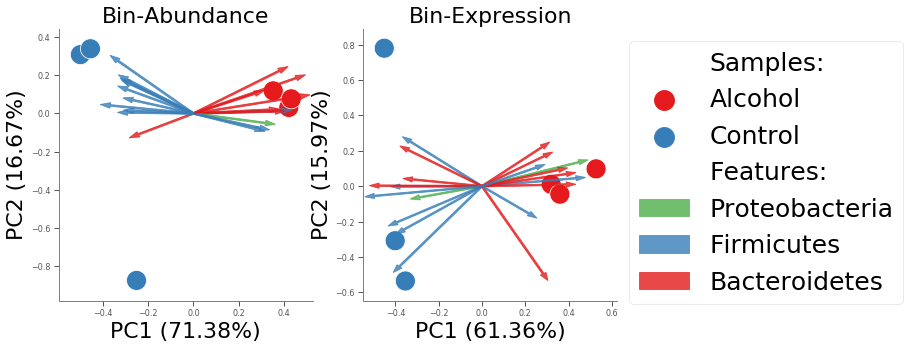

In [65]:
plt.style.use('ggplot')
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 10}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8


pallet_ = {'Alcohol':'#e41a1c',
           'Control':'#377eb8'}
taxmap = {'Bacteroidales':'#e41a1c', 'Campylobacterales':'#377eb8',
          'Clostridiales':'#4daf4a', 'Erysipelotrichales':'#984ea3'}
taxmap = {'Bacteroidetes':'#e41a1c',
          'Firmicutes':'#377eb8',
          'Proteobacteria':'#4daf4a'}
n_features = 20
lr_feats = 5
tax_level = 2
lr_dfs = {}

fig, axn = plt.subplots(1,2,figsize=(10,5),
                        sharex=False,
                        sharey=False)

for ord_, ax, title_ in zip([binabund_biplot, bintrnscrpt_biplot],
                            axn.flatten(),
                            ['Bin-Abundance','Bin-Expression']):
    
    s_ord = pd.concat([ord_.samples, mf],
                      axis=1, sort=True)
    sns.scatterplot(x=0,y=1,
                    hue='treatment',
                    s=400,
                    data=s_ord,
                    ax=ax,
                    palette=pallet_)
    ax.legend_.remove()
    ax.set_title(title_, fontsize=22, color='black')
    ax.set_xlabel('PC1 (%.2f%%)' % (ord_.proportion_explained[0]*100),
                  fontsize=22, color='black')
    ax.set_ylabel('PC2 (%.2f%%)' % (ord_.proportion_explained[1]*100),
                  fontsize=22, color='black')
    
    # add feature arrows 
    f_ord = pd.concat([ord_.features,
                       tax_transctrp.rename({1:'taxonomy'}, axis=1)],
                      axis=1, sort=True)
    f_ord['taxonomy'] = f_ord.index + ';' + f_ord['taxonomy']
    f_ord['taxonomy'] = [x.split(';')[tax_level] if len(x.split(';')) > tax_level else np.nan
                         for x in f_ord['taxonomy']]
    f_ord = f_ord.dropna(subset=['taxonomy'])
    f_ord = f_ord.sort_values(0)
    f_ord_plot = pd.concat([f_ord.iloc[:n_features//2, :],
                            f_ord.iloc[-n_features//2:, :]])
    
    # List of RGB triplets
    tax_classes = set(f_ord['taxonomy'])
    rgb_values = sns.color_palette("Set1", len(tax_classes))
    hex_values = [to_hex(c) for c in rgb_values]
    # Map label to RGB
    #taxmap = dict(zip(tax_classes, hex_values))

    # add arrows 
    annots = []
    seqs = []
    for i in range(n_features):
        annots.append(ax.arrow(0, 0,
                               f_ord_plot.iloc[i,0] * -2.2,
                               f_ord_plot.iloc[i,1] * -2.2,
                               color=taxmap[f_ord_plot.iloc[i,-1]],
                               alpha=0.8,
                               length_includes_head=True,
                               head_width=.03, width=.009))
        seqs.append(f_ord_plot.iloc[i,-1])
        
    # remove all grids, backrounds etc ...
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('grey')
    # get the log-ratio
    f_ord_plot = pd.concat([f_ord.iloc[:lr_feats//2, :],
                            f_ord.iloc[-lr_feats//2:, :]])
    mf_lr = mf.copy()
    num = f_ord_plot[f_ord_plot.taxonomy.isin(['Bacteroidetes'])].index
    den = f_ord_plot[f_ord_plot.taxonomy.isin(['Firmicutes'])].index
    print(num)
    print(den)
    bin_transcript_ = bin_transcript + 1.0
    lr = pd.DataFrame(np.log(bin_transcript_.loc[num,:].sum(0)) \
                      - np.log(bin_transcript_.loc[den,:].sum(0)))
    mf_lr['log-ratio'] = lr.reindex(mf_lr.index)
    lr_dfs[title_] = mf_lr

#handles, labels = ax.get_legend_handles_labels()
#legend = ax.legend(handles[1:],labels[1:],
#            prop={'size':25}, loc=2, 
#            handletextpad=0.1,
#            bbox_to_anchor=(-0.8, 1.35),
#            fancybox=True, framealpha=0.1,ncol=2
#            , facecolor="white",
#            edgecolor='black')

set_annot = {k:v for v, k in zip(annots, seqs)}
# generate legend from last iterations     
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend([handles[0]] + handles[1:] \
                   + [handles[0]] + list(set_annot.values()),
                   ['Samples:'] + labels[1:] + \
                   ['Features:'] + list(set_annot.keys()), 
                   loc=2, 
                         bbox_to_anchor=(1.0, 1.0),
                         prop={'size':25},
                         fancybox=True, framealpha=0.5, 
                         ncol=1, markerscale=2, facecolor="white")


    
# save the figure to file
plt.savefig('results/plots/rpca-sample-loading.pdf',dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()

In [66]:

bacter = ['bin.147','bin.153']
lach = ['bin.94', 'bin.210', 'bin.71']

abdundlr = pd.DataFrame(np.log(bin_abund.loc[bacter, :].sum())\
                        - np.log(bin_abund.loc[lach, :].sum()).sort_index(),
                        columns=['log_ratio_abundance'])
expreslr = pd.DataFrame(np.log(bin_transcript.loc[bacter, :].sum())\
                        - np.log(bin_transcript.loc[lach, :].sum()).sort_index(),
                       columns=['log_ratio_expression'])
mf_lr = pd.concat([expreslr, abdundlr, mf], axis=1,sort=False)


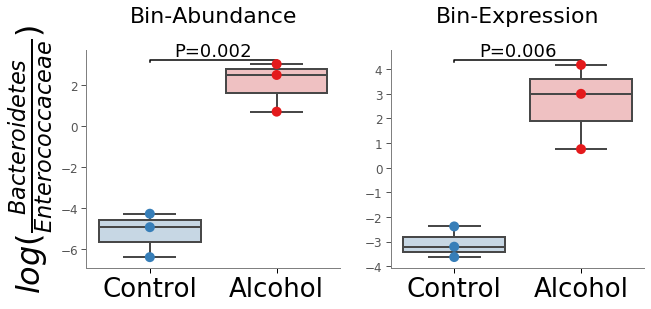

In [67]:
plt.style.use('ggplot')
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 25}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 26
plt.rcParams['ytick.labelsize'] = 12
pallet_ = {'Control':'#377eb8',
           'Alcohol':'#e41a1c'}

fig, axn = plt.subplots(1,2, figsize=(10,4))

for (title_, col_), ax in zip({'Bin-Abundance': 'log_ratio_abundance',
                               'Bin-Expression': 'log_ratio_expression'}.items(),
                              axn.flatten()):

    # plotting.
    sns.swarmplot(y=col_, x='treatment',
                data=mf_lr, palette=pallet_,
                ax=ax, s=10, order = ['Control','Alcohol'])
    sns.boxplot(y=col_,x='treatment',
                data=mf_lr,
                ax=ax, palette=pallet_, order = ['Control','Alcohol'])
    for patch in ax.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .3))
    # title etc ... 
    ax.set_title(title_, y=1.1, fontsize=22)
    ax.set_xlabel('', fontsize=25)
    if title_ == 'Bin-Abundance':
        ax.set_ylabel('$log(\\frac{%s}{%s})$' % ('Bacteroidetes',
                                                 'Enterococcaceae') ,
                              fontsize=32, color='black')
    else:
        ax.set_ylabel('')
    # statistical annotation
    t_res = ttest_ind(mf_lr[mf_lr.treatment.isin(['Control'])][col_].values,
                      mf_lr[mf_lr.treatment.isin(['Alcohol'])][col_].values)
    p_ = 'P=%.3f' % (t_res.pvalue)
    x1, x2 = 0, 1   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
    y, h, col = mf_lr[col_].max() + .1, .1, 'k'
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    ax.text((x1+x2)*.5, y+h, p_,
            ha='center', va='bottom',
            color=col, fontsize=18)
    #ps.append(t_res.pvalue)
    # remove all grids, backrounds etc ...
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('grey')
    ax.tick_params(axis='x', colors='black')
# save the figure to file
plt.savefig('results/plots/lr-bacter-firm.pdf',
            dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')
plt.show()